In [1]:
#Import Necessary Libraries 
import geopandas as gpd
import os
import fiona
import rasterio
import rasterio.mask
from rasterio import features
from rasterio.features import shapes
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling

import geopandas as gpd 
import pandas as pd
import numpy as np 

import sentinelsat
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import datetime
from datetime import date 

import json
import requests
import zipfile

from osgeo import gdal
import glob

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import imageio
import cv2
import copy
from copy import copy 
from scipy import misc

In [3]:
#IMPORT BANDS 2,3,4,5 FROM 2021 IMAGREY AND WRITE OUT A STACK
#WE'LL USE THE 20 METER RESOLUTION AS 10M DOES INCLUDE A NIR BAND AND 60M WOULD BE TOO COARSE
#Linking To images 

current_dir=os.getcwd()
print(current_dir)

images_location = current_dir + r'\finalproj_img_stor'
print(images_location)

img21 = images_location + r'\S2B_MSIL2A_20210629T154809_N0300_R054_T18STJ_20210629T200758\S2B_MSIL2A_20210629T154809_N0300_R054_T18STJ_20210629T200758\GRANULE\L2A_T18STJ_A022531_20210629T155547\IMG_DATA\R20m'
bands21 = [img21 + '\T18STJ_20210629T154809_B02_20m.jp2', #blue
           img21 + '\T18STJ_20210629T154809_B03_20m.jp2', #green
           img21 + '\T18STJ_20210629T154809_B04_20m.jp2', #red
           img21 + '\T18STJ_20210629T154809_B05_20m.jp2', #nir 
          ]
bands21

src = rasterio.open(bands21[0])
print(src)

#Checking metadata
meta = src.meta
print(meta)

#updating metadata
meta.update(count=len(bands21))
meta.update(driver='GTiff')
print(meta)

#Write 4 band image out 
with rasterio.open('C:/Users/cfcni/finalproj_img_stor/2021ffx.tif', 'w', **meta) as dst:
    for id, layer in enumerate(bands21, start=1):
        with rasterio.open(layer) as src:
            dst.write(src.read(1), id)
            print('Image Written!')

C:\Users\cfcni
C:\Users\cfcni\finalproj_img_stor
<open DatasetReader name='C:/Users/cfcni/finalproj_img_stor/S2B_MSIL2A_20210629T154809_N0300_R054_T18STJ_20210629T200758/S2B_MSIL2A_20210629T154809_N0300_R054_T18STJ_20210629T200758/GRANULE/L2A_T18STJ_A022531_20210629T155547/IMG_DATA/R20m/T18STJ_20210629T154809_B02_20m.jp2' mode='r'>
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 5490, 'height': 5490, 'count': 1, 'crs': CRS.from_epsg(32618), 'transform': Affine(20.0, 0.0, 199980.0,
       0.0, -20.0, 4400040.0)}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 5490, 'height': 5490, 'count': 4, 'crs': CRS.from_epsg(32618), 'transform': Affine(20.0, 0.0, 199980.0,
       0.0, -20.0, 4400040.0)}
Image Written!
Image Written!
Image Written!
Image Written!


Shape File Projection:  epsg:4269
Image Projection EPSG:32618


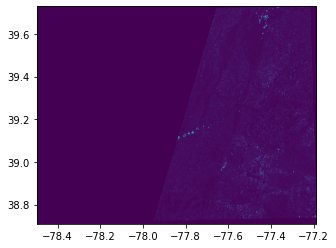

Image Clipped


In [4]:
#Read 4-band image back into Python 
ffx2021_4 = rasterio.open('C:/Users/cfcni/finalproj_img_stor/2021ffx.tif')
ffx2021_4

#Read Shape File 
shape_file = gpd.read_file(r'C:\Users\cfcni\Desktop\SPR 22 GIS\GGS 416 SAT\final_proj_test1\cb_2018_us_county_5m\fairfax_city.shp')

#Check Projections of Image and Shapefile 
print('Shape File Projection: ', shape_file.crs)
print('Image Projection', ffx2021_4.crs)

#Shape File Projection: epsg:4269
#Images Projection: EPSG:32618

#Specify ouptut projection system 
dst_crs = 'epsg:4269'

#I had to place the entire path in otherwise i would get errors about ambiguity, .all() or .any() wouldn't work
input_imagery_file = (r'C:/Users/cfcni/finalproj_img_stor/2021ffx.tif')
#Save location and file name
transformed_imagery_file = (r'C:/Users/cfcni/finalproj_img_stor/transform_2021ffx_city.tif')

#Transformation process
with rasterio.open(input_imagery_file) as imagery:
    transform, width, height = calculate_default_transform(imagery.crs, dst_crs, imagery.width, imagery.height, *imagery.bounds)
    kwargs = imagery.meta.copy()
    kwargs.update({'crs': dst_crs, 'transform': transform, 'width': width, 'height': height})
    with rasterio.open(transformed_imagery_file, 'w', **kwargs) as dst:
        for i in range(1, imagery.count + 1):
            reproject(
                source=rasterio.band(imagery, i),
                destination=rasterio.band(dst, i),
                src_transform=imagery.transform,
                src_crs=imagery.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
            
#Replot image after CRS transformation 
tr_imagery = rasterio.open(r'C:/Users/cfcni/finalproj_img_stor/transform_2021ffx_city.tif')
show(tr_imagery)
tr_imagery.crs

 
#re-read shape file 
with fiona.open(r'C:\Users\cfcni\Desktop\SPR 22 GIS\GGS 416 SAT\final_proj_test1\cb_2018_us_county_5m\fairfax_city.shp', 'r') as shapefile:
    shapes = [feature['geometry'] for feature in shapefile]

#read transformed image 
with rasterio.open(r'C:/Users/cfcni/finalproj_img_stor/transform_2021ffx_city.tif') as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop = True)
    out_meta = src.meta
    
#save clipped imagery 
out_meta.update({
    'driver':'GTiff',
    'height': out_image.shape[1],
    'width': out_image.shape[2],
    'transform':out_transform})

with rasterio.open(r'C:/Users/cfcni/finalproj_img_stor/clipped_ffx_city_2021.tif', 'w', **out_meta) as dest:
    dest.write(out_image)

print('Image Clipped')


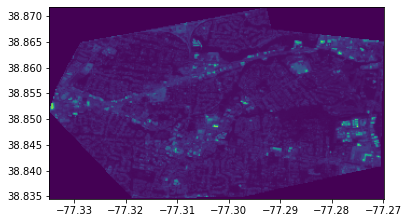

<AxesSubplot:>

In [2]:
#Now lets open our clipped raster 
clipped_image = rasterio.open(r'C:/Users/cfcni/finalproj_img_stor/clipped_ffx_city_2021.tif')
show(clipped_image)

In [3]:
#CALCULATING NDVI

#need to read image 
clip_r = clipped_image.read()

#Avoid Errors with 'true divide' 
np.seterr(divide='ignore', invalid='ignore')

#NDVI transformation
ndvi = (clip_r[3].astype(float) - clip_r[2].astype(float)) / (clip_r[3] + clip_r[2])

#Get max and Min Values, excluding NAn
print(np.nanmin(ndvi)) 
print(np.nanmax(ndvi))

#our minimum NDVI value is: -0.32759057512034456
#our maximum NDVI value is: 0.6987951807228916

-0.32759057512034456
0.6987951807228916


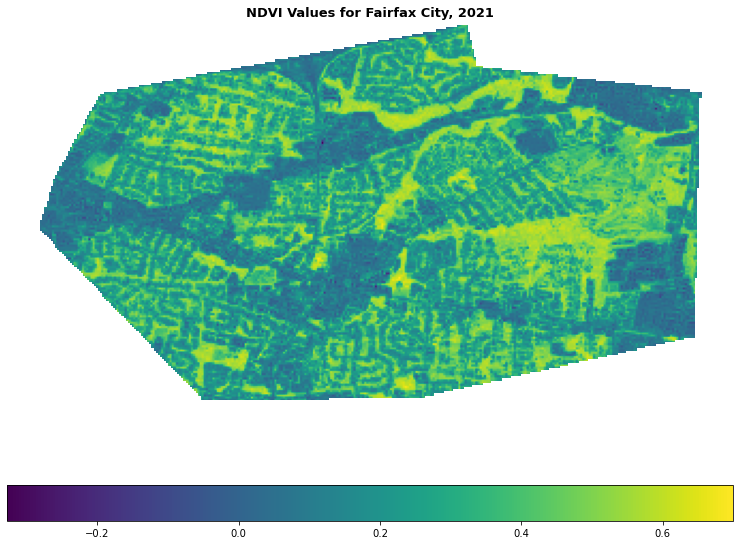

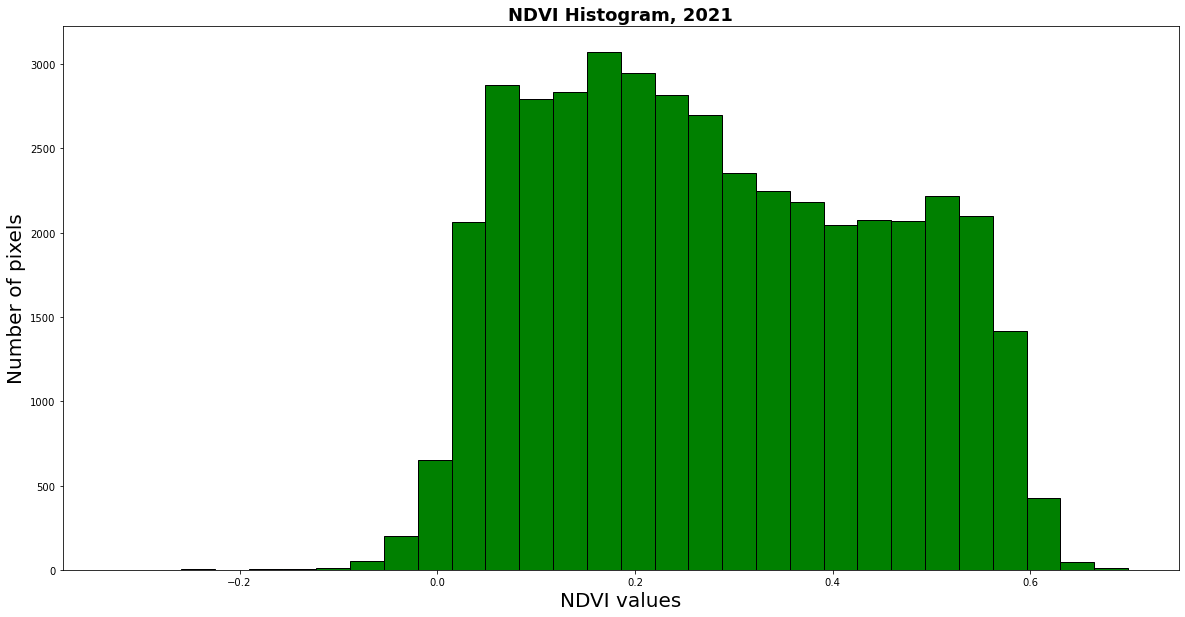

In [4]:
#VISUALIZING NDVI TRANSFORMATION 

from matplotlib import colors

#apply colorscheme for better visualization 
class MidpointNormalize(colors.Normalize):
   
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
       
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y), numpy.isnan(value))

    
#Interpretation 
min = np.nanmin(ndvi)
max = np.nanmax(ndvi)

#set custom midpoint for analysis
mid = 0.1

#Set color scheme of plot 
colormap = plt.cm.hot 
norm = MidpointNormalize(vmin=min, vmax=max, midpoint=mid)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111)

cbar_plot = ax.imshow(ndvi)
ax.axis('off')
ax.set_title('NDVI Values for Fairfax City, 2021', fontsize = 13, fontweight = 'bold')
cbar = fig.colorbar(cbar_plot, orientation = 'horizontal', shrink = 0.65)

plt.show()


#Generate histogram
#Define a new figure
fig2 = plt.figure(figsize=(20,10))

# Give this new figure a subplot, which will contain the histogram itself
ax = fig2.add_subplot(111)

# Add a title & (x,y) labels to the plot
plt.title("NDVI Histogram, 2021", fontsize=18, fontweight='bold')
plt.xlabel("NDVI values", fontsize=20)
plt.ylabel("Number of pixels", fontsize=20)


# For the x-axis, we want to count every pixel that is not an empty value
x = ndvi[~np.isnan(ndvi)]
color = 'g'
# call 'hist` with our x-axis, bins, and color details
ax.hist(x,bins=30,color=color,histtype='bar', ec='black')

# Save the generated figure to an external image file
#fig2.savefig("ndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.5)

plt.show()

In [8]:
#EXPORTING NDVI IMAGE TO SINGLE BAND RASTER 

#get the metadata of original GeoTIFF:
meta = src.meta
print(meta)

# get the dtype of our NDVI array:
ndvi_dtype = ndvi.dtype
#ndvi_dtype = ndvi.astype('uint16')
print(ndvi_dtype)

#set the source metadata as kwargs we'll use to write the new data:
kwargs = meta

#update the 'dtype' value to match our NDVI array's dtype:
kwargs.update(dtype=ndvi_dtype)

#update the 'count' value since our output will no longer be a 4-band image:
kwargs.update(count=1)

# Finally, use rasterio to write new raster file 'data/ndvi.tif':
with rasterio.open('ndvi_2021.tif', 'w', **kwargs) as dst:
        dst.write(ndvi, 1)
        print('image written')

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 6270, 'height': 4876, 'count': 4, 'crs': CRS.from_epsg(4269), 'transform': Affine(0.00020899863035328986, 0.0, -78.49897820389461,
       0.0, -0.00020899863035328986, 39.729043259692325)}
float64
image written


EPSG:4269
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


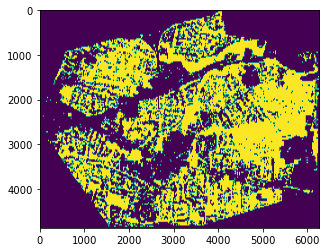

({'type': 'Polygon', 'coordinates': [[(3871.0, 110.0), (3871.0, 137.0), (3892.0, 137.0), (3892.0, 110.0), (3871.0, 110.0)]]}, 1.0)
Output contains 1567 shapes
shapefile created


C:\Users\cfcni\anaconda3\envs\sia\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [15]:
#Bring Back in Single Band NDVI Raster 
ndvi_img_o = rasterio.open('ndvi_2021.tif')

#Checking CRS 
print(ndvi_img_o.crs)     #EPSG: 4269

ndvi_img21 = ndvi_img_o.read()
ndvi_img21

#Change data type 
ndvi_img21 = np.float32(ndvi_img21)
ndvi_img21

#create empty frame to store vegetation values 
tree_index = np.zeros(ndvi_img21.shape)

#Filter out low and high values 
tree_index[(ndvi_img21 >= 0.25) & (ndvi_img21 < 0.69)] = 1
#tree_index

#Currently tree_index is a list, we'll convert it to a numpy array and then geojson
tree_index21 = np.array(tree_index)
print(tree_index21)

#Convert from float64 to float32 first
tree_index21 = tree_index21.astype('float32')
show(tree_index21)
tree_index21.dtype

#Convert numpy array into geojson 
my_shapes = shapes(tree_index21)

for my_shape in my_shapes:
    print(my_shape)
    break 
    
#Define Folder name for ouput 
output_folder = 'tree_shapes'

#Check if Folder exists 
if not os.path.exists(output_folder):
    os.mkdir(output_folder) # If not, then make the directory
    print('folder created')
    
#Transform raster coordinates into geographic coordinates 
def transform_coordinates(pair):
    """
    This function takes a pair of raster coordinates 
    and returns the geographic coordinates. 
    
    """
    geo_coords = ndvi_img_o.xy(pair[1],pair[0])

    return [geo_coords[0], geo_coords[1]]

#Create Empty Dataframe
output = [] 

for tree_shape in my_shapes:
    coords = tree_shape[0]['coordinates'][0]
    geographic_coords = [transform_coordinates(pair) for pair in coords]
    # Specify a geojson with our transformed coordinates
    output.append({
        'geometry' : {
            'type':'LineString',
            'coordinates': geographic_coords,
            },
        'properties': {},
    }) 

print('Output contains {} shapes'.format(len(output))) #Contains 5606 shape
#output

#Write shapefile out
data_to_write = gpd.GeoDataFrame.from_features(output, crs='epsg:4269')
data_to_write.to_file('tree_shapes/tree_shape21.shp')
print('shapefile created')